In [497]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import ToFloat 
import cv2
import glob
from tqdm import tqdm
import cv2

In [498]:
train_transforms = A.Compose(
    [
        A.Resize(height=224,width=224),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomRotate90(),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(),
        #A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        
        #T.RandomBrightness(p=0.5),
        ToTensorV2(),
        
    ]
)

test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=224),
        #A.CenterCrop(height=224, width=225),
        A.Resize(height=224,width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
       
    ]
)

In [499]:
train_data_path = 'pollen' 
#test_data_path = 'images/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('\\')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
#test_image_paths = []
#for data_path in glob.glob(test_data_path + '/*'):
 #   test_image_paths.append(glob.glob(data_path + '/*'))

#test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\n".format(len(train_image_paths), len(valid_image_paths)))



train_image_path example:  pollen\Pyrus elaeagnifolia\3.jpg
class example:  Acantholimon acerosum
Train size: 1410
Valid size: 353



In [500]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [501]:
#######################################################
#               Define Dataset Class
#######################################################

class pollenDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = pollenDataset(train_image_paths,train_transforms)
valid_dataset = pollenDataset(valid_image_paths,test_transforms) #test transforms are applied
#test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [502]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[2][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[2][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  260


In [503]:
#type(train_dataset[2][0])


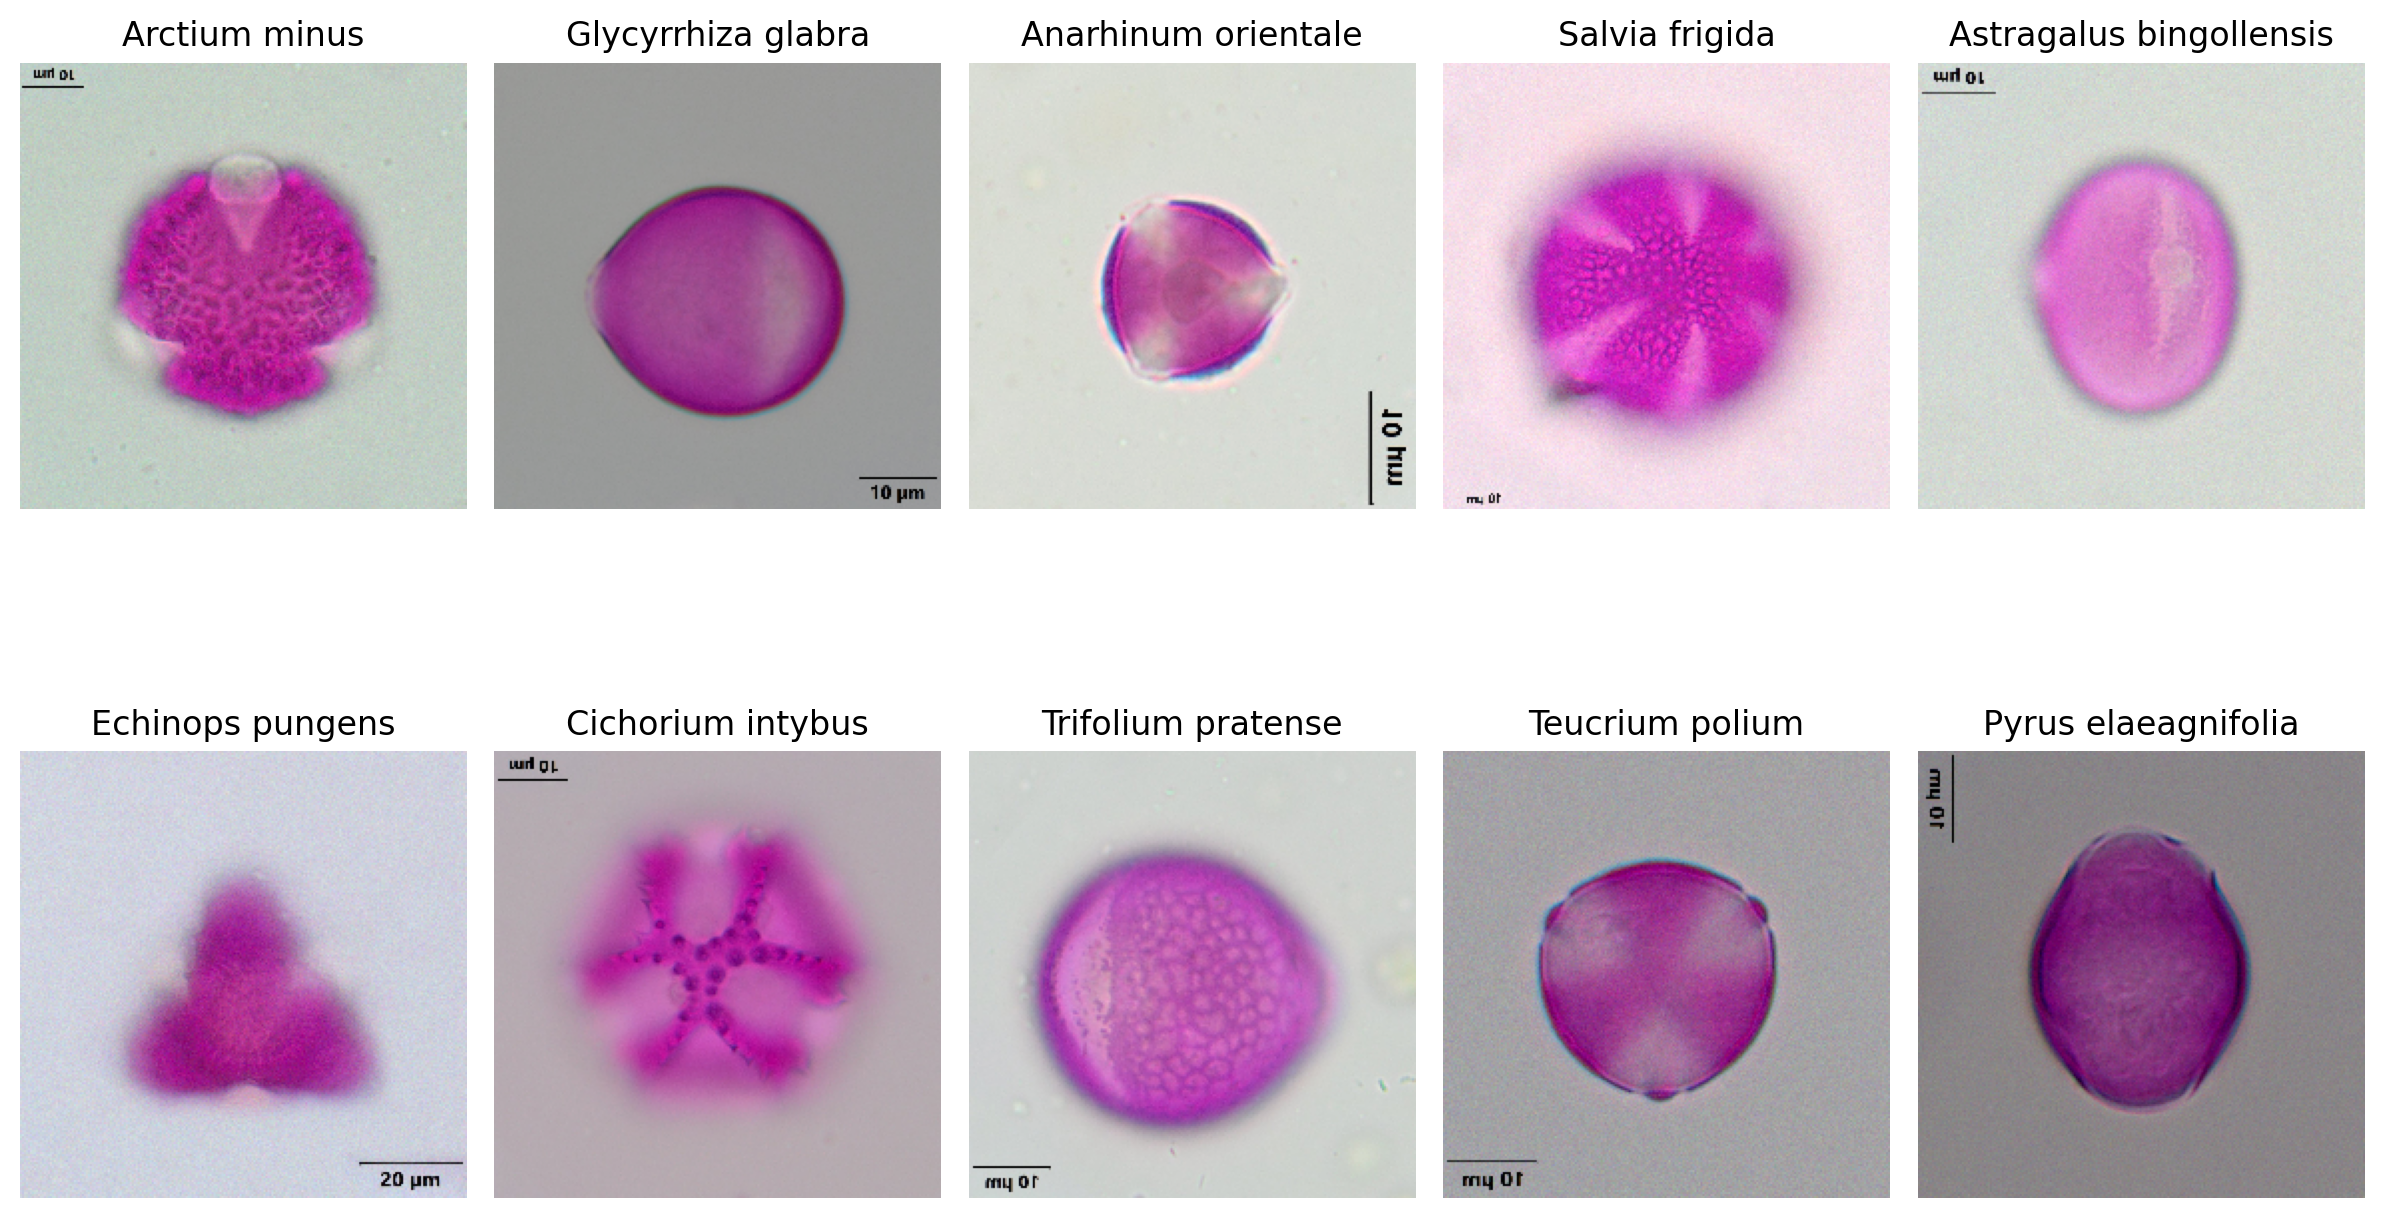

In [504]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
          idx = np.random.randint(1,len(train_image_paths))
          image, lab = dataset[idx]
          ax.ravel()[i].imshow(image)
          ax.ravel()[i].set_axis_off()
          ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [505]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


#test_loader = DataLoader(
 #   test_dataset, batch_size=64, shuffle=False

In [506]:
loaders = {"train": train_loader, "val": valid_loader}

In [507]:
dataset_length = {"train" : len(train_dataset) , "val" : len(valid_dataset)}

In [508]:
next(iter(train_loader))[1].shape


torch.Size([64])

In [509]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [510]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [511]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [512]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [513]:
import sys
from tqdm import tqdm
import time
import copy

In [514]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [515]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_deit_main


In [516]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=268, bias=True)
)


In [517]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [518]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=1.0)

In [519]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_length[phase]
            epoch_acc =  running_corrects.double() / dataset_length[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [520]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster
# I will come back after 10 epochs

Epoch 0/14
----------


100%|██████████| 23/23 [02:34<00:00,  6.74s/it]


train Loss: 5.3460 Acc: 0.0369


100%|██████████| 6/6 [00:35<00:00,  5.84s/it]


val Loss: 4.8690 Acc: 0.1445

Epoch 1/14
----------


100%|██████████| 23/23 [02:33<00:00,  6.66s/it]


train Loss: 4.4258 Acc: 0.1426


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


val Loss: 4.4092 Acc: 0.1586

Epoch 2/14
----------


100%|██████████| 23/23 [02:35<00:00,  6.74s/it]


train Loss: 3.7783 Acc: 0.2631


100%|██████████| 6/6 [00:34<00:00,  5.82s/it]


val Loss: 4.0176 Acc: 0.2408

Epoch 3/14
----------


100%|██████████| 23/23 [02:27<00:00,  6.42s/it]


train Loss: 3.2914 Acc: 0.3631


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


val Loss: 3.7679 Acc: 0.2805

Epoch 4/14
----------


100%|██████████| 23/23 [02:35<00:00,  6.75s/it]


train Loss: 2.9608 Acc: 0.4440


100%|██████████| 6/6 [00:33<00:00,  5.64s/it]


val Loss: 3.6435 Acc: 0.3059

Epoch 5/14
----------


100%|██████████| 23/23 [02:29<00:00,  6.51s/it]


train Loss: 2.7587 Acc: 0.4936


100%|██████████| 6/6 [00:36<00:00,  6.02s/it]


val Loss: 3.5331 Acc: 0.3428

Epoch 6/14
----------


100%|██████████| 23/23 [02:26<00:00,  6.38s/it]


train Loss: 2.5582 Acc: 0.5376


100%|██████████| 6/6 [00:33<00:00,  5.63s/it]


val Loss: 3.5965 Acc: 0.3343

Epoch 7/14
----------


100%|██████████| 23/23 [02:31<00:00,  6.57s/it]


train Loss: 2.4041 Acc: 0.6071


100%|██████████| 6/6 [00:34<00:00,  5.68s/it]


val Loss: 3.4669 Acc: 0.3484

Epoch 8/14
----------


100%|██████████| 23/23 [02:20<00:00,  6.10s/it]


train Loss: 2.2788 Acc: 0.6433


100%|██████████| 6/6 [00:31<00:00,  5.19s/it]


val Loss: 3.3874 Acc: 0.3853

Epoch 9/14
----------


100%|██████████| 23/23 [02:21<00:00,  6.14s/it]


train Loss: 2.1410 Acc: 0.7099


100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


val Loss: 3.3339 Acc: 0.3994

Epoch 10/14
----------


100%|██████████| 23/23 [02:14<00:00,  5.84s/it]


train Loss: 2.1358 Acc: 0.6894


100%|██████████| 6/6 [00:32<00:00,  5.47s/it]


val Loss: 3.3538 Acc: 0.3853

Epoch 11/14
----------


100%|██████████| 23/23 [02:18<00:00,  6.03s/it]


train Loss: 2.0187 Acc: 0.7383


100%|██████████| 6/6 [00:32<00:00,  5.46s/it]


val Loss: 3.2760 Acc: 0.3796

Epoch 12/14
----------


100%|██████████| 23/23 [02:22<00:00,  6.21s/it]


train Loss: 1.9870 Acc: 0.7298


100%|██████████| 6/6 [00:33<00:00,  5.53s/it]


val Loss: 3.2692 Acc: 0.4051

Epoch 13/14
----------


100%|██████████| 23/23 [02:13<00:00,  5.80s/it]


train Loss: 1.9688 Acc: 0.7489


100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


val Loss: 3.2652 Acc: 0.3994

Epoch 14/14
----------


100%|██████████| 23/23 [02:13<00:00,  5.82s/it]


train Loss: 1.8747 Acc: 0.7766


100%|██████████| 6/6 [00:34<00:00,  5.75s/it]

val Loss: 3.2181 Acc: 0.4193

Training complete in 44m 54s
Best Val Acc: 0.4193


In [521]:
torch.hub.load

<function torch.hub.load(repo_or_dir, model, *args, source='github', trust_repo=None, force_reload=False, verbose=True, skip_validation=False, **kwargs)>